In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import imread
import json
import gzip
import tarfile
import random
from hangul_utils import check_syllable, split_syllable_char, split_syllables, join_jamos
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

print("packs loaded")
%connect_info

packs loaded
{
  "stdin_port": 35218,
  "shell_port": 33988,
  "control_port": 49196,
  "ip": "127.0.0.1",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "hb_port": 43002,
  "key": "4c34ed99-2437-42f6-94b3-4eecafbdadc1",
  "kernel_name": "",
  "iopub_port": 33799
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-47015a3a-2566-4570-a22e-4dec6c893e67.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
en_chset = []
en_chset.extend(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
en_chset.extend(["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",\
              "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"])
en_chset.extend(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N",\
              "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"])
en_chset.extend(["(", ")", "'", "\"", ".", ",", ":", ";", "!", "?", "/", "@", "#", "$",\
              "%", "^", "&", "*", "[", "]", "{", "}", "<", ">", "~", "-"])

ko_chset_cho = ["ㄱ", "ㄲ", "ㄴ", "ㄷ", "ㄸ", "ㄹ", "ㅁ", "ㅂ", "ㅃ", "ㅅ", "ㅆ", "ㅇ", "ㅈ", "ㅉ", "ㅊ", "ㅋ", "ㅌ", "ㅍ", "ㅎ"]
ko_chset_jung = ["ㅏ", "ㅐ", "ㅑ", "ㅒ", "ㅓ", "ㅔ", "ㅕ", "ㅖ", "ㅗ", "ㅘ", "ㅙ", "ㅚ", "ㅛ", "ㅜ", "ㅝ", "ㅞ", "ㅟ", "ㅠ", "ㅡ", "ㅢ", "ㅣ"]
ko_chset_jong = ["X", "ㄱ", "ㄲ", "ㄳ", "ㄴ", "ㄵ", "ㄶ", "ㄷ", "ㄹ", "ㄺ", "ㄻ", "ㄼ", "ㄽ", "ㄾ", "ㄿ", "ㅀ", "ㅁ", "ㅂ", "ㅄ", "ㅅ", "ㅆ", "ㅇ", "ㅈ", "ㅊ", "ㅋ", "ㅌ", "ㅍ", "ㅎ"]

# Read training and test images from file
def get_image_index_from_file(indexf, dataf):
    index_data = []
    with gzip.open(indexf, 'rt') as arc:
        index_data.extend(json.load(arc))
        print("index loaded")
        arc.close()

    # Read-stream mode r|*
    with tarfile.open(dataf, "r|*") as tar:
        print("tar opened")
        img_data = []
        for i, member in enumerate(index_data):
            if i%10000 == 1:
                print("%2.0f%% complete (%d / %d)" % (i / len(index_data) * 100, i, len(index_data)))
            ti = tar.next()
            if ti.name != member['path']:
                print("ERROR: order doesn't match")
                break;
            f = tar.extractfile(ti)
            img_data.append(1 - (imread(f)/255))
        img = np.array(img_data)
        del img_data
        print("image loaded")
        tar.close()
    return (index_data, img)

def get_label(index_data):
    # len + 1 for one 'invalid' label
    label_ko_cho = np.zeros([len(index_data), len(ko_chset_cho)+1])
    label_ko_jung = np.zeros([len(index_data), len(ko_chset_jung)+1])
    label_ko_jong = np.zeros([len(index_data), len(ko_chset_jong)+1])
    label_en = np.zeros([len(index_data), len(en_chset)+1])
    for i, member in enumerate(index_data):
        target = member['target'] # Target Character
        # Is Hangeul?
        if (check_syllable(target)):
            splited = split_syllable_char(target)
            label_en[i][len(en_chset)] = 1
            label_ko_cho[i][ko_chset_cho.index(splited[0])] = 1
            label_ko_jung[i][ko_chset_jung.index(splited[1])] = 1
            if len(splited) < 3:
                label_ko_jong[i][0] = 1
            else:
                label_ko_jong[i][ko_chset_jong.index(splited[2])] = 1
        else :
            label_ko_cho[i][len(ko_chset_cho)] = 1
            label_ko_jung[i][len(ko_chset_jung)] = 1
            label_ko_jong[i][len(ko_chset_jong)] = 1
            label_en[i][en_chset.index(target)] = 1
            
    # Concatenate all labels
    label = np.concatenate((label_ko_cho, label_ko_jung, label_ko_jong, label_en), axis=1)
    print("label loaded")
    return label

def get_all():
    index_data_en, img_en = get_image_index_from_file('data/en/index.json.gz', 'data/en/data.tar.gz')
    index_data_ko, img_ko = get_image_index_from_file('data/ko/index.json.gz', 'data/ko/data.tar.gz')
    index_data = index_data_en + index_data_ko
    img = np.concatenate((img_en, img_ko))
    del img_en
    del img_ko
    label = get_label(index_data)
    return (index_data, img, label)
        
index_data, img, label = get_all()

index loaded
tar opened
 0% complete (1 / 79200)
13% complete (10001 / 79200)
25% complete (20001 / 79200)
38% complete (30001 / 79200)
51% complete (40001 / 79200)
63% complete (50001 / 79200)
76% complete (60001 / 79200)
88% complete (70001 / 79200)
image loaded
index loaded
tar opened
 0% complete (1 / 211500)
 5% complete (10001 / 211500)
 9% complete (20001 / 211500)
14% complete (30001 / 211500)
19% complete (40001 / 211500)
24% complete (50001 / 211500)
28% complete (60001 / 211500)
33% complete (70001 / 211500)
38% complete (80001 / 211500)
43% complete (90001 / 211500)
47% complete (100001 / 211500)
52% complete (110001 / 211500)
57% complete (120001 / 211500)
61% complete (130001 / 211500)
66% complete (140001 / 211500)
71% complete (150001 / 211500)
76% complete (160001 / 211500)
80% complete (170001 / 211500)
85% complete (180001 / 211500)
90% complete (190001 / 211500)
95% complete (200001 / 211500)
99% complete (210001 / 211500)
image loaded
label loaded


In [3]:
def getIndex(l, indexes):
    return [l[i] for i in indexes]

def shuffle(n, *lists):
    perm = np.random.permutation(n)
    lists = list(lists)
    for i in range(len(lists)):
        if hasattr(lists[i], "shape"):
            lists[i] = lists[i][perm]
        else:
            lists[i] = getIndex(lists[i], perm)
    return tuple(lists)

img, label, index_data = shuffle(img.shape[0], img, label, index_data)

print("shuffled")

shuffled


In [4]:
trainimg = img[:-15000]
trainlabel = label[:-15000]
testimg = img[-15000:-3000]
testlabel = label[-15000:-3000]
cvimg = img[-3000:]
cvlabel = label[-3000:]
randidx = np.random.randint(trainimg.shape[0], size=2)

(290700, 32, 32)
{'path': '0167437.png', 'font': 'NanumGothic', 'weight': 'BOLD', 'target': '취'}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
{'path': '0184568.png', 'font': 'Batang', 'weight': 'BOLD', 'target': '톼'}
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.

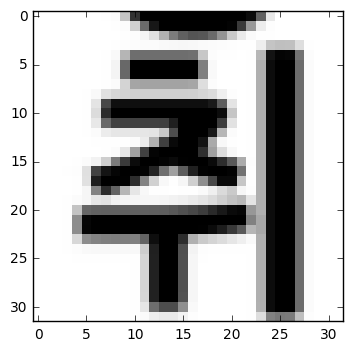

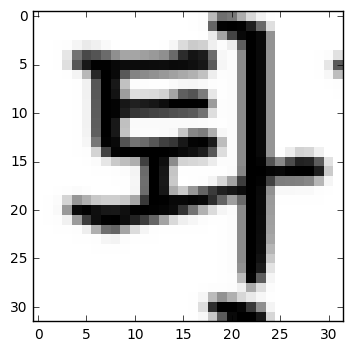

In [5]:
print(img.shape)
plt.figure()
plt.imshow(img[0], interpolation='none')
print(index_data[0])
print(label[0])

plt.figure()
plt.imshow(img[1], interpolation='none')
print(index_data[1])
print(label[1])

In [6]:
def get_batch(i, batch_size, input_var):
    if batch_size > input_var.shape[0]:
        return input_var
    start = (i*batch_size)%input_var.shape[0]
    overflow = start + batch_size - input_var.shape[0]
    if overflow <= 0:
        return input_var[start:start+batch_size]
    else:
        return np.r_[input_var[start:], input_var[:overflow]]
    
def flatten_cnn(layer):
    layer_shape = layer.get_shape().as_list()
    n_out = layer_shape[1] * layer_shape[2] * layer_shape[3]
    return tf.reshape(layer, [-1, n_out])

def build_nn(shape, X):
    n_before = int(X.get_shape()[1])
    W = tf.Variable(tf.truncated_normal([n_before, shape], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[shape]))
    return tf.matmul(X, W)+b

def build_cnn(cnn_shape, patch_shape, X, stride=1):
    n_before = int(X.get_shape()[3])
    W = tf.Variable(tf.truncated_normal([patch_shape[0], patch_shape[1], n_before, cnn_shape], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[cnn_shape]))
    layer = tf.nn.relu(tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME') + b)
    return layer

def max2d_pool(layer):
    return tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def slice_label(tf_label, len_tuple):
    cur = 0
    sliced = []
    for l in len_tuple:
        sliced.append(tf.slice(tf_label, [0, cur], [-1, l]))
        cur += l
    return tuple(sliced)

print("function loaded")

function loaded


In [7]:
X = tf.placeholder(tf.float32, [None, 32, 32])
Y = tf.placeholder(tf.float32, [None, 160])
keep_prob = tf.placeholder(tf.float32)

Y_cho, Y_jung, Y_jong, Y_en = slice_label(Y,
                                         (len(ko_chset_cho)+1,
                                         len(ko_chset_jung)+1,
                                         len(ko_chset_jong)+1,
                                         len(en_chset)+1))
# Small inception model
# http://laonple.blog.me/220704822964
X_reshape = tf.reshape(X, [-1, 32, 32, 1])
cnn_1_5 = build_cnn(12, [5,5], X_reshape)
cnn_1_3 = build_cnn(36, [3,3], X_reshape)
cnn_1_concat = tf.concat(3, [cnn_1_5, cnn_1_3])
cnn_1_pool = max2d_pool(cnn_1_concat) # 16 * 16 * 48

cnn_2_5 = build_cnn(18, [5,5], cnn_1_pool)
cnn_2_3 = build_cnn(48, [3,3], cnn_1_pool)
cnn_2_1 = build_cnn(30, [1,1], cnn_1_pool)
cnn_2_concat = tf.concat(3, [cnn_2_5, cnn_2_3, cnn_2_1])
cnn_2_pool = max2d_pool(cnn_2_concat) # 8 * 8 * 96

cnn_3_5_reduce = build_cnn(18, [1,1], cnn_2_pool)
cnn_3_5 = build_cnn(36, [5,5], cnn_3_5_reduce)
cnn_3_3_reduce = build_cnn(64, [1,1], cnn_2_pool)
cnn_3_3 = build_cnn(96, [3,3], cnn_3_3_reduce)
cnn_3_1 = build_cnn(60, [1,1], cnn_2_pool)
cnn_3_concat = tf.concat(3, [cnn_3_5, cnn_3_3, cnn_3_1])
cnn_3_pool = max2d_pool(cnn_3_concat) # 4 * 4 * 192

dense_1 = tf.nn.relu(build_nn(1024, flatten_cnn(cnn_3_pool)))
dropout_1 = tf.nn.dropout(dense_1, keep_prob)

logit = build_nn(label.shape[1], dropout_1)
logit_cho, logit_jung, logit_jong, logit_en = slice_label(logit,
                                         (len(ko_chset_cho)+1,
                                         len(ko_chset_jung)+1,
                                         len(ko_chset_jong)+1,
                                         len(en_chset)+1))
h_cho = tf.nn.softmax(logit_cho)
h_jung = tf.nn.softmax(logit_jung)
h_jong = tf.nn.softmax(logit_jong)
h_en = tf.nn.softmax(logit_en)

learning_rate = tf.placeholder(tf.float32)
cost_cho = tf.nn.softmax_cross_entropy_with_logits(logit_cho, Y_cho)
cost_jung = tf.nn.softmax_cross_entropy_with_logits(logit_jung, Y_jung)
cost_jong = tf.nn.softmax_cross_entropy_with_logits(logit_jong, Y_jong)
cost_en = tf.nn.softmax_cross_entropy_with_logits(logit_en, Y_en)
cost = cost_cho + cost_jung * 1.5 + cost_jong * 0.5 + cost_en
cost_mean = tf.reduce_mean(cost) # mean of batch set

train = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_cho = tf.equal(tf.argmax(Y_cho,1), tf.argmax(h_cho,1))
correct_jung = tf.equal(tf.argmax(Y_jung,1), tf.argmax(h_jung,1))
correct_jong = tf.equal(tf.argmax(Y_jong,1), tf.argmax(h_jong,1))
correct_two = tf.logical_or(tf.logical_and(correct_cho, tf.logical_or(correct_jung, correct_jong)),
                           tf.logical_and(correct_jung, correct_jong))
correct_ko = tf.logical_and(tf.logical_and(correct_cho, correct_jung), correct_jong)
correct_en = tf.equal(tf.argmax(Y_en,1), tf.argmax(h_en,1))
correct_all = tf.logical_and(correct_ko, correct_en)
accuracy = tf.reduce_mean(tf.cast(correct_all, tf.float32))
accuracy_two = tf.reduce_mean(tf.cast(correct_two, tf.float32))
accuracy_cho = tf.reduce_mean(tf.cast(correct_cho, tf.float32))
accuracy_jung = tf.reduce_mean(tf.cast(correct_jung, tf.float32))
accuracy_jong = tf.reduce_mean(tf.cast(correct_jong, tf.float32))
accuracy_ko = tf.reduce_mean(tf.cast(correct_ko, tf.float32))
accuracy_en = tf.reduce_mean(tf.cast(correct_en, tf.float32))

sess = tf.Session()
print("session loaded")

session loaded


In [8]:
def init_session():
    sess.run(tf.initialize_all_variables())
    print("session initialized")
    
def fetch_in_batch(fetch_tuple, imgset, labelset, i, batchsize):
    batch_x = get_batch(i, batchsize, imgset)
    batch_y = get_batch(i, batchsize, labelset)
    return sess.run(fetch_tuple, feed_dict={X:batch_x, Y:batch_y, keep_prob:1})
    
def batch_accuracy(imgset, labelset):
    allsize = imgset.shape[0]
    batchsize = 100
    batch_per_epoch = int(allsize/batchsize)
    batch_accuracy = 0
    for i in range(batch_per_epoch):
        batch_accuracy += fetch_in_batch(accuracy, imgset, labelset, i, batchsize)
    return batch_accuracy / batch_per_epoch

def get_accuracy_no_batch(imgset, labelset):
    return sess.run((accuracy, accuracy_cho, accuracy_jung, accuracy_jong, accuracy_two, accuracy_en),
                                        feed_dict={X:imgset, Y:labelset, keep_prob:1})

def get_accuracy(imgset, labelset, batch=False):
    if batch:
        allsize = imgset.shape[0]
        batchsize = 100
        batch_per_epoch = int(allsize/batchsize)
        temp_tuple = 0, 0, 0, 0, 0, 0
        for i in range(batch_per_epoch):
            batch_x = get_batch(i, batchsize, imgset)
            batch_y = get_batch(i, batchsize, labelset)
            temp_tuple = tuple([item1 + item2 for item1, item2 in
                                zip(temp_tuple,
                                    get_accuracy_no_batch(batch_x, batch_y))])
        tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en = tuple([item / batch_per_epoch for item in temp_tuple])
    else:
        tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en = get_accuracy_no_batch(imgset, labelset)
    return tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en
    
def print_accuracy(imgset, labelset, batch=False):
    tacc, tacc_cho, tacc_jung, tacc_jong, tacc_two, tacc_en = get_accuracy(imgset, labelset, batch)
    print ("overall accuracy = %.3f                          " % tacc)
    print ("two of three = %.3f" % tacc_two)
    print ("cho = %.3f" % tacc_cho)
    print ("jung = %.3f" % tacc_jung)
    print ("jong = %.3f" % tacc_jong)
    print ("en = %.3f" % tacc_en)

def do_training(is_console=False, lr_init = 0.003):
    trainsize = trainimg.shape[0]
    batchsize = 100
    batch_per_epoch = int(trainsize/batchsize)
    print ("Training %d, mini-batch %d * %d" % (trainsize, batchsize, batch_per_epoch))

    lr = lr_init
    for i in range(batch_per_epoch*5):
        if i % 200 == 0 :
            tacc = get_accuracy(cvimg, cvlabel, False)[0]
            print ("%6dth epoch : cv accuracy = %.3f                  " % (i // batch_per_epoch, tacc))
            
        if i % batch_per_epoch == 0 :
            print_accuracy(testimg, testlabel, True)

        batch_x = get_batch(i, batchsize, trainimg)
        batch_y = get_batch(i, batchsize, trainlabel)
        cur_cost = sess.run((train, cost_mean), feed_dict={X:batch_x, Y:batch_y, keep_prob:0.5, learning_rate:lr})[1]
        if(is_console):
            print ("%dth... lr = %.2e, cost = %.2e\r" % (i, lr, cur_cost), end="")
        lr = lr * (1 - 0.0003)
    print("train complete--------------------------------")
    print("test accuracy ---")
    print_accuracy(testimg, testlabel, True)
    print("train accuracy ---")
    print_accuracy(trainimg, trainlabel, True)
    
def error_check(chset, pred_tf, label_tf, imgset, labelset):
    label_len = label_tf.get_shape()[1]
    n_error = np.zeros([label_len, label_len])
    n_all = np.zeros(label_len)
    new_chset = chset + ["inv"]
    
    allsize = imgset.shape[0]
    batchsize = 100
    batch_per_epoch = int(allsize/batchsize)
    for i in range(batch_per_epoch):
        h, y = fetch_in_batch((pred_tf, label_tf), imgset, labelset, i, batchsize)
        for j in range(batchsize):
            n_all[np.argmax(y[j])] += 1
            if (np.argmax(h[j]) != np.argmax(y[j])):
                n_error[np.argmax(y[j])][np.argmax(h[j])] += 1

    print ("Error rate")
    for i, ch in enumerate(new_chset):
        most_error = np.argmax(n_error[i])
        print ("%s : %2.0f%% (%4d / %4d)" %
               (ch, float(np.sum(n_error[i])) / n_all[i] * 100, np.sum(n_error[i]), n_all[i]), end="")
        if n_error[i][most_error] > 0:
            print ("%6d errors with %s" % (n_error[i][most_error], new_chset[most_error]))
        else:
            print ("")
            
def save_ckpt():
    saver = tf.train.Saver()
    saver.save(sess, "ch_recog_model_only_valid.ckpt")
    
def load_ckpt():
    saver = tf.train.Saver()
    saver.restore(sess, "ch_recog_model_only_valid.ckpt")
            
print("tf function loaded")

tf function loaded


In [11]:
print_accuracy(testimg, testlabel, True)

overall accuracy = 0.993                          
two of three = 1.000
cho = 0.999
jung = 0.998
jong = 0.999
en = 0.997


In [13]:
error_check(en_chset, h_en, Y_en, testimg, testlabel)

Error rate
0 :  0% (   0 /   37)
1 :  3% (   1 /   36)     1 errors with l
2 :  0% (   0 /   43)
3 :  0% (   0 /   31)
4 :  0% (   0 /   43)
5 :  0% (   0 /   41)
6 :  0% (   0 /   35)
7 :  0% (   0 /   49)
8 :  0% (   0 /   36)
9 :  0% (   0 /   40)
a :  0% (   0 /   31)
b :  0% (   0 /   40)
c :  0% (   0 /   37)
d :  0% (   0 /   36)
e :  0% (   0 /   36)
f :  0% (   0 /   35)
g :  0% (   0 /   36)
h :  0% (   0 /   39)
i :  5% (   2 /   38)     1 errors with t
j :  0% (   0 /   40)
k :  0% (   0 /   29)
l : 34% (  12 /   35)    10 errors with I
m :  0% (   0 /   41)
n :  0% (   0 /   30)
o :  0% (   0 /   29)
p :  0% (   0 /   47)
q :  0% (   0 /   44)
r :  0% (   0 /   44)
s :  0% (   0 /   38)
t :  0% (   0 /   37)
u :  0% (   0 /   31)
v :  0% (   0 /   32)
w :  0% (   0 /   38)
x :  0% (   0 /   34)
y :  0% (   0 /   37)
z :  5% (   2 /   40)     2 errors with Z
A :  0% (   0 /   41)
B :  0% (   0 /   31)
C :  0% (   0 /   33)
D :  0% (   0 /   38)
E :  0% (   0 /   38)
F :  3%

In [15]:
error_check(ko_chset_jung, h_jung, Y_jung, testimg, testlabel)

Error rate
ㅏ :  0% (   3 /  874)     3 errors with ㅣ
ㅐ :  0% (   0 /  648)
ㅑ :  0% (   1 /  300)     1 errors with ㅣ
ㅒ :  0% (   0 /   58)
ㅓ :  1% (   4 /  776)     2 errors with ㅔ
ㅔ :  1% (   4 /  515)     4 errors with ㅖ
ㅕ :  0% (   0 /  513)
ㅖ :  1% (   2 /  167)     1 errors with ㅔ
ㅗ :  0% (   0 /  662)
ㅘ :  1% (   2 /  302)     2 errors with ㅚ
ㅙ :  0% (   0 /  165)
ㅚ :  0% (   1 /  403)     1 errors with ㅢ
ㅛ :  0% (   0 /  225)
ㅜ :  0% (   3 /  626)     2 errors with ㅗ
ㅝ :  0% (   0 /  204)
ㅞ :  0% (   0 /  162)
ㅟ :  0% (   0 /  381)
ㅠ :  1% (   3 /  298)     2 errors with ㅜ
ㅡ :  0% (   2 /  649)     2 errors with ㅜ
ㅢ :  0% (   0 /  100)
ㅣ :  1% (   4 /  715)     2 errors with ㅏ
inv :  0% (   0 / 3257)
